# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163010 sha256=a29afe41a252a254a1292981a9939626775282c868a91b863481431daa887444
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# basic libraries for numeric and dataframe calculations
import numpy as np
import pandas as pd

# basic library for data visualization
import matplotlib.pyplot as plt

# seaborn for data visualization
import seaborn as sns

# a dictionary output that does not raise a key error
from collections import defaultdict

# a performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# performance metric from surprise
from surprise import accuracy

# class to parse a file containing ratings
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting hte rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# reading the dataset
electronics = pd.read_csv('/content/drive/MyDrive/DSML/Week 11/Project 3/ratings_Electronics.csv')

In [ ]:
# adding column names to dataset
electronics.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [ ]:
#inspecting first 5 rows of dataframe
electronics.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
# creating a copy of the dataframe into new variable df
df = electronics

In [ ]:
#dropping timestamp from df
df.drop('timestamp', axis=1, inplace=True)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# checking shape of df_final
df_final.shape

(65290, 3)

**Observations:**

We have reduced the size of the dataset to a much more manageable size, consisting of 65,290 data points.

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**

User and Product ID columns are of type object. The rating column is of type float64, which is appropriate and will allow us to perform calculations.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations:**

df_final does not contain any null values. We can proceed with our EDA without any additional processing.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations:**

The rating column is heavily skewed left. The mean rating is 4.295, which is less than the median of 5.0. The lowest rating is 1 and highest is 5, as expected. Overall, a very large percentage of ratings are 5.0 stars.

### **Checking the rating distribution**

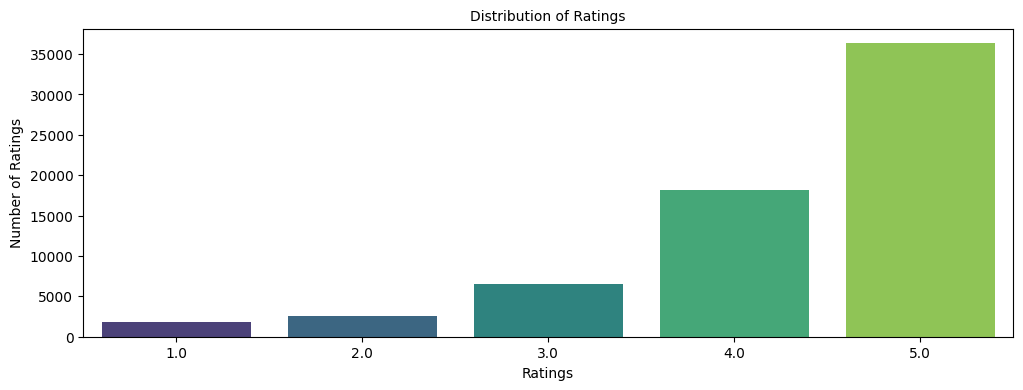

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize= (12,4))
sns.countplot(x='rating', data=df_final, palette='viridis')

plt.tick_params(labelsize = 10)
plt.title('Distribution of Ratings', fontsize = 10)
plt.xlabel('Ratings', fontsize = 10)
plt.ylabel('Number of Ratings', fontsize = 10);

**Observations:**

As noted from our statistical summary, the data is heavily left skewed. The 5.0 ratings column has neary twice as many ratings as the next closest category, 4.0. Ratings of 3.0 and below are total only about 12,000 out of the approximately 65,000 total ratings.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
unique_users = df_final['user_id'].nunique()
unique_users

1540

In [ ]:
df_final.shape[0]/unique_users

42.396103896103895

In [ ]:
unique_prods = df_final['prod_id'].nunique()
unique_prods

5689

In [ ]:
df_final.shape[0]/unique_prods

11.476533661451924

**Observations:**

There are 1540 unique users in the dataset. This means the average user has left 42 reviews. Interestingly, our cutoff for users was a minimum of 50 reviews, but presumably that number was lowered after we removed products with less than 5 ratings.

Regarding products, there are 5,689 unique products that have been rated. Given the total number of ratings, this means that each product has about 11.5 reviews on average.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().head(10)

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: user_id, dtype: int64

**Observations:**

The top 10 users ranked by number of ratings are listed above, with their user_id's and the corresponding number of reviews. The top reviewer has left 295 reviews, and the user in 10th place has left 179 reviews.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values(by = ['avg_rating'], ascending=False, inplace=True)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prod(data, n, min_interaction=30):

  # Finding products with minimum number of interactions
  recommendations = data[data['rating_count'] >= min_interaction]

  # Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by = 'avg_rating', ascending=False)

  return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_prod(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_prod(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1,5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=.7, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options = sim_options, verbose=False, random_state=1)

# Fit the model on the training data
algo_knn_user.fit(trainset)

# predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user)

RMSE: 1.0552
Precision:  0.855
Recall:  0.48
F_1 score:  0.615


In [ ]:
accuracy.rmse(predictions)

RMSE: 1.0552


1.0551559636074466

**Observations:**

Our initial KNN model has relatively good performance, with an 85% percision. However, recall is below 50%, bringing the F_1 score to 61.5%.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

The model has returned was_impossible as True, so the prediction that has been returned is 4.29, the global mean of the ratings column. The algorithm has cited that there are not enough neighbors for this data point to create a prediction from.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# creating a list of unique users
uniqueUsers = df_final['user_id'].unique().tolist()

# copying unique users to new list
users_not_seen = uniqueUsers
product = 1400501466

# itterating through unique users to remove those that have seen product 1400501466
for user in uniqueUsers:
  if 1400501466 in df[df['prod_id'] == product]:
    users_not_seen.remove(user)

# displaying list of users
users_not_seen

['A3LDPF5FMB782Z',
 'A1A5KUIIIHFF4U',
 'A2XIOXRRYX0KZY',
 'AW3LX47IHPFRL',
 'A1E3OB6QMBKRYZ',
 'A19N3S7CBSU6O7',
 'A2ZR3YTMEEIIZ4',
 'A3CLWR1UUZT6TG',
 'A5JLAU2ARJ0BO',
 'A1P4XD7IORSEFN',
 'A341HCMGNZCBIT',
 'A3HPCRD9RX351S',
 'A1DQHS7MOVYYYA',
 'ALUNVOQRXOZIA',
 'A3G7BEJJCPD6DS',
 'A2JXS1JII6SAUD',
 'A1C82BC5GNABOA',
 'A1VHCO8RQFIGQJ',
 'A2Z9S2RQD542CP',
 'A2QIC4G483SQQA',
 'A3L6L5O89JTX2T',
 'A1OGCPMSIVK7G4',
 'A18HE80910BTZI',
 'A3F9CBHV4OHFBS',
 'A1T1YSCDW0PD25',
 'ABVYGB2TKBO8F',
 'A11ED8O95W2103',
 'A3NCIN6TNL0MGA',
 'ASHJAZC9OA9NS',
 'A105TOJ6LTVMBG',
 'A14JBDSWKPKTZA',
 'A3QX0ERX4D03TF',
 'A13WREJ05GMRA6',
 'A3N8O68DOEQ2FE',
 'A3J8A5L5AF5TX9',
 'A2HRHF83I3NDGT',
 'A1R3GN9MEJFXM3',
 'A3963R7EPE3A7E',
 'A2JOPUWVV0XQJ3',
 'AAW7X3GRD8GY9',
 'A3V8P0O224OBDB',
 'AY6A8KPYCE6B0',
 'A212MDP6K4VJS5',
 'A28X0LT2100RL1',
 'A1V3TRGWOMA8LC',
 'A1NZLRAZJGD99W',
 'A1522TN5FVJL0Y',
 'A3UXW18DP4WSD6',
 'A3CW0ZLUO5X2B1',
 'A3TBMGNSEQBWIL',
 'AEZJTA4KDIWY8',
 'A22CW0ZHY3NJH8',
 'A2V7EO331SFUF6',
 

In [ ]:
if 'A34BZM6S9L7QI4' in users_not_seen:
  print('A34BZM6S9L7QI4 has not seen the product.')

else:
  print('A34BZM6S9L7QI4 has seen the product')

A34BZM6S9L7QI4 has not seen the product.


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Observations:**

We can confirm that user A34BZM6S9L7QI4 has not seen product 1400501466.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# grouping df by product type
final_rating.loc['1400501466']

avg_rating      3.333333
rating_count    6.000000
Name: 1400501466, dtype: float64

In [ ]:
algo_knn_user.predict('A1ZPUEHF4AES86', 'B00B9KOCYA')

Prediction(uid='A1ZPUEHF4AES86', iid='B00B9KOCYA', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

The algorithm has predicted a rating of 4.29 for this user-product combination. Interestingly, the mean rating across the dataset is also 4.29, and the average rating for teh product is 3.33. Once again, the model has cited that there are not enough neighbors to create a prediction from.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid  ={'k': [10, 20, 30], 'min_k': [3, 9, 15],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9724483619107076
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_algo_optimized_user = KNNBasic(sim_options = sim_options, k = 30, min_k = 3, Verbose=False)

# Training the algorithm on the trainset
sim_algo_optimized_user.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_algo_optimized_user, k = 10)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9896
Precision:  0.842
Recall:  0.475
F_1 score:  0.607


**Observations:**

With these hyper-tuned parameters, we haev seen an improvement in the algorithm's RMSE score, dropping from 1.055 down to .989. Overall though, the precision/recall and therefore f-1 score have decreased, from 61.5% to 60.7%. This means unfortunately that the end user will not see any improved performance of the recommendations they are receiving.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_algo_optimized_user.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_algo_optimized_user.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

Unfortunately, the model still is unable to make a prediction for these two data points with not enough neighbors - it has returned the global mean of 4.29.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_algo_optimized_user.get_neighbors(0, k=5)


[7, 12, 14, 23, 47]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
A3LDPF5FMB782Z_recommendations = get_recommendations(data = df_final, user_id = 'A3LDPF5FMB782Z', top_n = 5, algo = sim_algo_optimized_user)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
A3LDPF5FMB782Z_recommendations_df = pd.DataFrame(A3LDPF5FMB782Z_recommendations, columns =['prod_id', 'pred_rating'])

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_item = KNNBasic(sim_options = sim_options, verbose=False, random_state=1)

# Fit the model on the training data
algo_knn_item.fit(trainset)

# predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_item)

RMSE: 1.0697
Precision:  0.833
Recall:  0.472
F_1 score:  0.603


In [ ]:
predictions

[Prediction(uid='A2DXENZNO2JT4F', iid='B005JZP3CQ', r_ui=4.0, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='AGOH8N902URMW', iid='B0019UGCLG', r_ui=2.0, est=4.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A9Y5O2R4D6EH5', iid='B001TH7GSW', r_ui=4.0, est=4.0, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A35C2IVVQR1HTK', iid='B003ES61EE', r_ui=2.0, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='A38RMU1Y5TDP9', iid='B00HPZ4HZW', r_ui=4.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3HC7NWLKCPX4X', iid='B00CMQTVK0', r_ui=2.0, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='A1ODOGXEYECQQ8', iid='B00AKONZ3U', r_ui=5.0, est=4.111111111111111, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid='A31ICLWQ9CSHRS', iid=

**Observations:**

Changing the model to an item-item similarity system has provided little difference in the performance metrics. The RMSE is marginally higher, and F-1 score is marginally better.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

Similarly to our user-user model, this model is not able to find enough neighbors to create a prediciton for this data point, and has returned the global rating mean.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

Once again, the model does not have enough neighbors to make a prediction.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid  ={'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9759755326064775
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, min_k = 9, k = 30)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(model = sim_item_item_optimized, k = 10)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9894
Precision:  0.829
Recall:  0.471
F_1 score:  0.601


**Observations:**

The tuned model is again performing slightly better, with a drop in RMSE from 1.0697 to .9894. The F-1 score has however dropped slightly, again indicating that the end user will not see any improved recommendations.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

Just as before, the model has not been able to locate enough neighbors to these datapoints to create a prediction

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
# finding similar items to item 0
sim_item_item_optimized.get_neighbors(0, k=5)

[117, 151, 258, 288, 477]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
A1A5KUIIIHFF4U_recommendations = get_recommendations(data = df_final, user_id = 'A1A5KUIIIHFF4U', top_n = 5, algo = sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
A1A5KUIIIHFF4U_recommendations_df = pd.DataFrame(data = A1A5KUIIIHFF4U_recommendations, columns = ['prod_id', 'rating'])

In [ ]:
A1A5KUIIIHFF4U_recommendations_df.head()

,prod_id,rating
0,1400532655,4.291367
1,1400599997,4.291367
2,9983891212,4.291367
3,B00000DM9W,4.291367
4,B00000J1V5,4.291367


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
algo_svd = SVD(random_state=1)

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(model = algo_svd)

RMSE: 0.9296
Precision:  0.876
Recall:  0.488
F_1 score:  0.627


**Observations:**

The RMSE for our baseline SVD model is already pretty strong, at .9296, which is the strongest starting points for any of our models thus far.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
algo_svd.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.134651034794736, details={'was_impossible': False})

**Observations:**

The model was able to provide a prediction for this user/product datapoint of 4.13.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
algo_svd.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.251243941476115, details={'was_impossible': False})

**Observations:**

The model was able to provide a prediction for this user/product datapoint of 4.25.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
                 'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8991676458264246
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
algo_svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.4, random_state=1)

# Train the algorithm on the trainset
algo_svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(model = algo_svd_optimized)

RMSE: 0.9216
Precision:  0.883
Recall:  0.49
F_1 score:  0.63


**Observations:**

There has been marginal improvement over the previous untuned SVD model. RMSE has gone down from .9296 to .9216 and F-1 score has increased 0.3%.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_svd_optimized.predict('A3LDPF5FMB782Z','1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.8924079109817824, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_svd_optimized.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.000229299274616, details={'was_impossible': False})

**Observations:**

The optimized model was able to give predictions of 3.89 and 4.00 for the different user/product pairs. These ratings are approximately .25 points lower than the previous predictions. This change is interesting given the small change in performance metrics but may indicate a more accurate model.

### **Conclusion and Recommendations**



*   This dateset of user-item reviews while large in volume prooved somewhat difficult to work with and produce insightful recommendations from.
*   The KNNBasic algorithm had a difficult time finding any nearest neighbors for the particular user-item combinations we were looking to predict.
*   Employing Singular Value Decomposition allowed us to extract some hidden features from the dataset which seemed to allow us to create some predictions for the user-item pairs we were investigating.
*   Because SVD was sucessful and creating more meaningful predictions from the dataset, this might indicate that having additional informaiton about our customer base may be helpful in creating more meaningful predictions.
*   Amazon may want to look into ways to collect additional information about their customers and/or work with their data engineers to get that data into hands of data scientists, so that we may employ additional alogrithms, such as clustering techniques, to group customers by similar attributes that would help inform rating predictions.

